In [222]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


In [284]:
class SankeyNode:
    def __init__(self, x, y, name, value, label='{name}\n{value:,.0f}', label_pos='left center', label_opts=dict(fontsize=20), artist='rectangle', align_y='top', color='#FF33AA', **kwargs):
        '''
        @param x : left edge, typically the flow level, as a 0-indexed integer. 
        @param y : bottom edge, between [0, 1]
        '''
        self.x = x
        self.y = y
        self.name = name
        self.value = value # used for label only
        self.label = label
        self.label_pos = label_pos
        self.label_opts = label_opts
        self.artist_type = artist
        self.align_y = align_y
        self.color = color
        self.flow_pad = 0.01 # vertical padding between flow endpoints
        self.inflows = []
        self.outflows = []
        self.opts = kwargs


    def get_flow_y(self, i, side='inflows'):
        flows = getattr(self, side)
        if self.align_y == 'top':
            value_scale = self.value / (self.opts['height'] - self.flow_pad * (len(flows) - 1))
            y1 = self.y + self.opts['height'] - (np.sum([x.value for x in flows[:i]]) / value_scale + self.flow_pad * i)
            y0 = y1 - flows[i].value / value_scale
            return (y0, y1)
        else:
            raise NotImplementedError("align_y: " + align_y)

    def draw(self, ax):
        # Node
        if self.artist_type == 'rectangle':
            self.artist = mpatches.Rectangle((self.x, self.y), self.opts['width'], self.opts['height'])
        else:
            raise NotImplementedError("artist: {}".format(self.artist_type))
        self.artist.set_color(self.color)
        self.artist.set_edgecolor(None)
        ax.add_patch(self.artist)

        # Label
        if self.label:
            if self.label_pos == 'left center':
                x = self.x
                y = self.y + self.opts['height'] / 2
                ha = 'right'
                va = 'center'
            else:
                raise NotImplementedError("label_pos: " + self.label_pos)
            ax.text(x, y, self.label.format(name=self.name, value=self.value), ha=ha, va=va, **self.label_opts)



class SankeyFlow:
    def __init__(self, src, des, value, curvature = 0, color='#AAAAAA66', **kwargs):
        self.value = value
        self.curvature = curvature
        self.color = color
        self.opts = kwargs
        self.node_pad = 0 # x padding from the node (sometimes they overlap), as fraction of distance between nodes in x

        self.src = src
        self.des = des
        self.src_i = len(src.outflows)
        self.des_i = len(des.inflows)
        src.outflows.append(self)
        des.inflows.append(self)

    def compile(self):

        if self.src.artist_type != 'rectangle':
            raise NotImplementedError("artist: {}".format(self.src.artist_type))
        if self.des.artist_type != 'rectangle':
            raise NotImplementedError("artist: {}".format(self.des.artist_type))

        x1 = self.src.x + self.src.opts['width'] + self.node_pad
        x2 = self.des.x - self.node_pad
        (y1_1, y1_2) = self.src.get_flow_y(self.src_i, 'outflows')
        (y2_1, y2_2) = self.des.get_flow_y(self.des_i, 'inflows')

        if self.curvature == 0:
            self.artist = mpatches.Polygon([
                [x1, y1_2], # top left
                [x2, y2_2], # top right
                [x2, y2_1], # bottom right
                [x1, y1_1], # bottom left
            ])
            self.artist.set_color(self.color)
            self.artist.set_edgecolor(None)
        else:
            raise NotImplementedError("curvature: {}".format(self.curvature))


class Sankey:
    '''
    This class creates and manages a sankey diagram. 
    '''

    def __init__(self, align_y='top', flow_color_mode='dest', flow_color_mode_alpha=0.6, **kwargs):
        self.align_y = align_y
        self.flow_color_mode = flow_color_mode
        self.flow_color_mode_alpha = flow_color_mode_alpha
        self.node_width = 0.03
        self.node_pad_y = 0.01
        self.cmap = plt.cm.tab10

    def find_node(self, name):
        for level,node_level in enumerate(self.nodes):
            for node in node_level:
                if node.name == name:
                    return (node, level)
        return (None, None)

    def sankey(self, flows, nodes):
        '''
        @param nodes : A list of node levels, from sources to destinations. In each level, a list of nodes as (name, value).
        '''
        _total_value_per_level = [sum(v for name,v in level) for level in nodes]
        max_level_value = np.max(_total_value_per_level)
        max_level_n = np.max([len(level) for level,val in zip(nodes,_total_value_per_level) if max_level_value - val < 1e-5])
        value_scale = max_level_value / (1 - self.node_pad_y * (max_level_n - 1))

        # Nodes
        self.nodes = []
        i = 0
        for x,node_level in enumerate(nodes):
            arr = []
            if self.align_y == 'top':
                y = 1
                for node in node_level:
                    if node[1] <= 0:
                        raise ValueError("Node value <= 0: {} {}".format(*node))
                    height = node[1] / value_scale 
                    arr.append(SankeyNode(x, y - height, *node, width=self.node_width, height=height, color=self.cmap(i % self.cmap.N)))
                    i += 1
                    y -= height + self.node_pad_y
            else:
                raise NotImplementedError("align_y: " + align_y)
            
            self.nodes.append(arr)

        # Flows
        self.flows = []
        for flow in flows:
            (src, src_level) = self.find_node(flow[0])
            (des, des_level) = self.find_node(flow[1])
            if not src:
                raise KeyError("Bad flow - couldn't find node: {}".format(flow[0]))
            if not des:
                raise KeyError("Bad flow - couldn't find node: {}".format(flow[1]))
            if flow[2] > src.value or flow[2] > des.value or flow[2] <= 0:
                raise ValueError("Bad flow - bad weight: {}".format(flow[2]))
            if des_level <= src_level:
                raise ValueError("Bad flow - flow is backwards: {}".format(flow))

            if 'dest' in self.flow_color_mode:
                color = des.color
            elif 'src' in self.flow_color_mode:
                color = src.color
            else:
                color = '#AAAAAA'
            color = mcolors.to_rgba(color)
            color = (*color[:3], color[3] * self.flow_color_mode_alpha)
            self.flows.append(SankeyFlow(src, des, flow[2], color=color))

    def compile(self):
        for flow in self.flows:
            flow.compile()

    def draw(self, ax=None):
        self.compile()

        # Get axes
        if ax is None:
            ax = plt.gca()

        # Draw nodes
        for node_level in self.nodes:
            for node in node_level:
                node.draw(ax)

        # Draw flow
        for flow in self.flows:
            ax.add_patch(flow.artist)

        #ax.axis(xmin=0, xmax=len(self.nodes)-1 + self.node_width, ymin=0, ymax=1)
        ax.axis('tight')
        ax.axis('off')

In [285]:
s = Sankey()

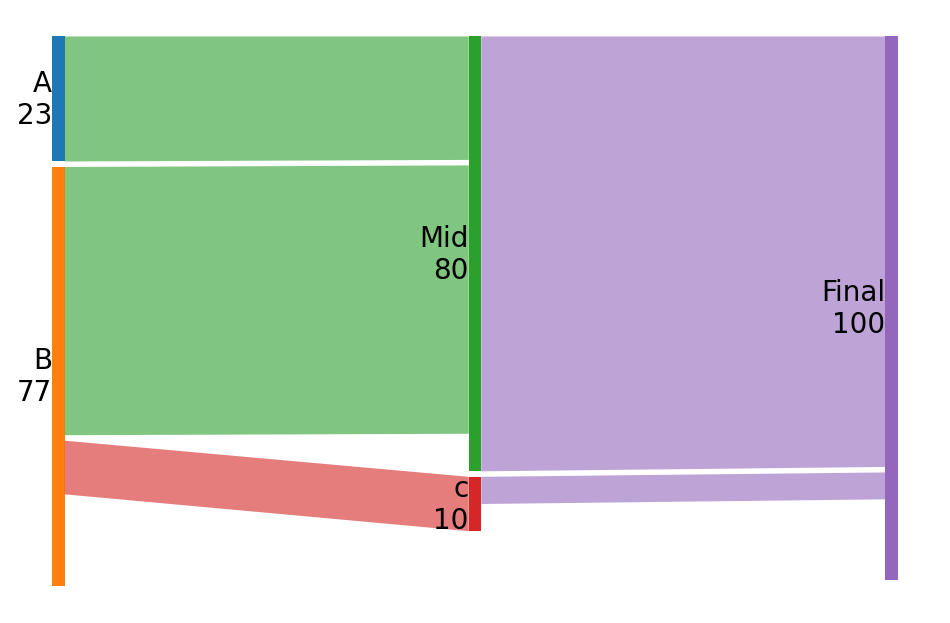

In [289]:
fig = plt.figure(
        figsize=(12, 8),
        dpi=100 # increase this to get better resolution
    )
s.sankey(
    [
        ['A', 'Mid', 23],
        ['B', 'Mid', 50],
        ['B', 'c', 10],
        ['Mid', 'Final', 80],
        ['c', 'Final', 5],
    ],
    [
        [
            ('A', 23),
            ('B', 77),
        ],
        [
            ('Mid', 80),
            ('c', 10)
        ],
        [
            ('Final', 100),
        ],
    ]
)
s.draw()